Importation des librairies

In [3]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns



Importation des jeux de données

In [4]:
# Les données statique sur les différents terminaux

df_static = pd.read_csv('./data/info_static.csv')
df_static.head()

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"
3,S86-T2,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,E/F
4,S86-T3,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"T3, Combo, CHAdeMO, E/F, T2"


In [5]:
# les données sur la méteo et le traffic

df_MT = pd.read_csv('./data/xtrain.csv')
df_MT.head()

,timestamp,temperature,wind_speed,wind_gust_speed,rain_level,traffic_state,average_flow
0,2019-11-25T00:00:00+00:00,8.7,11.0,24.0,0.0,Fluid,218.1
1,2019-11-25T01:00:00+00:00,8.8,9.0,20.0,0.0,Fluid,144.3
2,2019-11-25T02:00:00+00:00,8.9,8.0,18.0,0.0,Fluid,110.0
3,2019-11-25T03:00:00+00:00,8.8,7.0,18.0,0.0,Fluid,143.8
4,2019-11-25T04:00:00+00:00,8.8,10.0,23.0,0.0,Fluid,315.1


In [6]:
# les données sur l'évolution du status de chaque terminal au sein des différentes stations
df_usage = pd.read_csv('./data/ytrain_NpxebDC.csv')
df_usage.head()

/tmp/ipykernel_42652/4091091124.py:2: DtypeWarning: Columns (1,3,5,11,20,49,52,54,55,56,64,70,71,94,95,101,102,114,129,131,132,133,138,139,152,157,163,174,180,184,193,196,201,207,208,219,220,228,241,245,250,256,258,264,265,269,270,271,272,273) have mixed types. Specify dtype option on import or set low_memory=False.
  df_usage = pd.read_csv('./data/ytrain_NpxebDC.csv')


,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
0,2019-11-25T00:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
1,2019-11-25T00:15:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
2,2019-11-25T00:30:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
3,2019-11-25T00:45:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
4,2019-11-25T01:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN


**Nettoyage des différents jeu de données**

Nous allons dans un premier temps vérifier si nous avons des valeurs manquantes dans notre jeu de données et appliquer les méthodes appropriées pour les gérer (la suppression des lignes concernées ou le remplacement des valeurs manquantes par la moyenne, le mode,..)

In [7]:
# Obtenir la taille de notre jeu de données et vérifier s'il y'a des colonnes avec valeurs manquantes

print('la taille du jeu de données statique est:', df_static.shape)
missing_values_static= df_static.isnull().sum()
missing_values_static


la taille du jeu de données statique est: (273, 8)


t_id         0
s_id         0
latitude     0
longitude    0
street       0
city         0
zipcode      0
model        0
dtype: int64

In [8]:
print('la taille du jeu de données sur la méteo et le traffic est:', df_MT.shape)
missing_values_MT = df_MT.isnull().sum()
missing_values_MT

la taille du jeu de données sur la méteo et le traffic est: (8400, 7)


timestamp           0
temperature         4
wind_speed          7
wind_gust_speed     7
rain_level         49
traffic_state      59
average_flow       59
dtype: int64

Les données sur la météo et le trafic contiennent des valeurs manquantes. Nous allons remplacer les valeurs manquantes des variables numériques (average_flow, temperature, wind_speed, wind_gust_speed, rain_level) par leur **moyenne**, et pour la variable qualitative traffic_state, nous remplacerons les valeurs manquantes par le **mode**.

In [9]:

def remplacer_valeurs_manquantes(df):

    # Séparer les variables numériques et qualitatives
    variables_numeriques = df.select_dtypes(include=['float64', 'int64']).columns
    variables_qualitatives = df.select_dtypes(include=['object']).columns
    
    # Remplacer les valeurs manquantes des variables numériques par la moyenne
    for col in variables_numeriques:
        df[col] = df[col].fillna(df[col].mean())
    
    # Remplacer les valeurs manquantes des variables qualitatives par le mode
    for col in variables_qualitatives:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df


# Appliquer cette fonction à notre dataset sur la méteo et le traffic

df_MT=remplacer_valeurs_manquantes(df_MT)


In [10]:
print('la taille du jeu de données sur la méteo et le traffic est:', df_usage.shape)
missing_values_usage = df_usage.isnull().sum()
missing_values_usage

la taille du jeu de données sur la méteo et le traffic est: (31232, 274)


timestamp       0
S7-T1        1227
S2-T1         150
S19-T1       1227
S56-T3         68
             ... 
S97-T2       4761
S25-T1       5789
S25-T2       7239
S98-T2       7162
S99-T2       7277
Length: 274, dtype: int64

Pour nos données sur l'évolution de l'usage des terminaux de recharge, nous avons opté pour la suppression des lignes contenant des valeurs manquantes. Cette décision a été motivée par le fait que les données sont des observations ponctuelles, et leur imputation par des valeurs arbitraires (comme la moyenne ou le mode) aurait pu introduire un biais.

In [11]:
df_usage = df_usage.dropna()
df_usage.shape

(22862, 274)

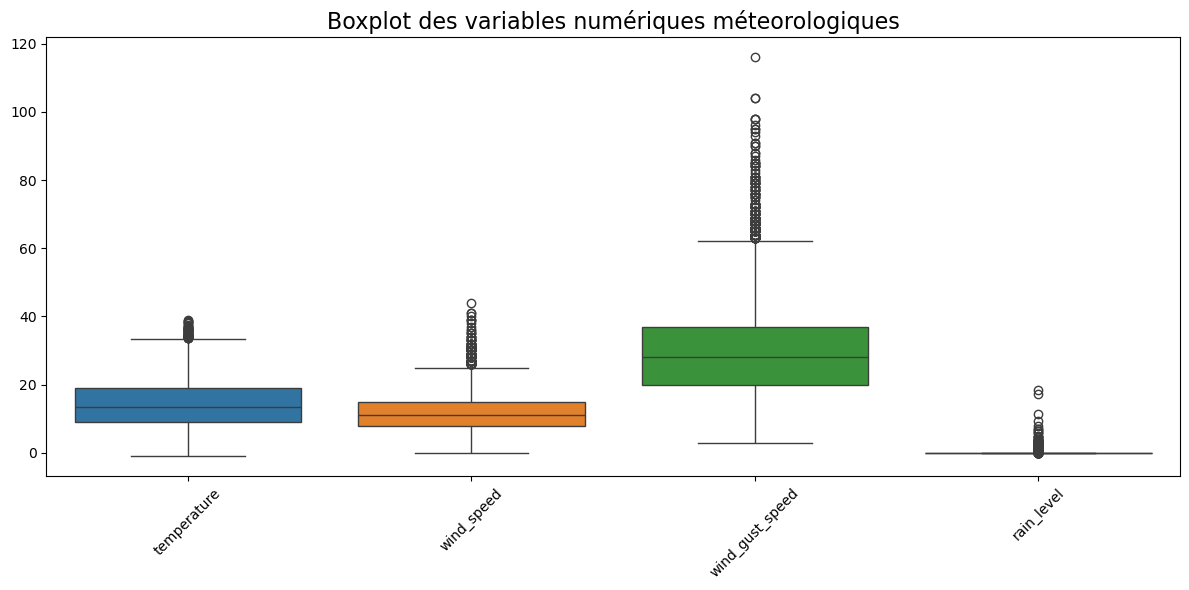

In [12]:

# Sélectionner les colonnes numériques sur la météo
numerical_columns = df_MT.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop(['average_flow'])

# Créer une figure avec des sous-graphes (subplots)
plt.figure(figsize=(12, 6))

# Créer un boxplot pour chaque colonne numérique
sns.boxplot(data=df_MT[numerical_columns])

# Ajouter un titre
plt.title("Boxplot des variables numériques méteorologiques", fontsize=16)

# Afficher le graphique
plt.xticks(rotation=45)  # Rotation des labels de colonnes pour plus de lisibilité
plt.tight_layout()  # Ajuste automatiquement l'espacement pour éviter que les éléments se chevauchent
plt.show()

Nous pouvons remarquer que la présence d'outliers est fréquente et pourrait refléter la réalité (comme des vitesses de vent élevées lors de tempêtes). Nous préférons donc conserver ces dernières

Analyse des valeurs unique dans mon jeu de données

In [13]:
print('Les différents états des terminaux présent sont:',pd.unique(df_usage.drop(columns=['timestamp']).values.ravel()))

Les différents états des terminaux présent sont: ['Down' 'Available' 'Passive' 'Offline' 'Charging']


In [14]:
print('les différents états du traffic dans mon jeu de données sont:',df_MT['traffic_state'].unique())

les différents états du traffic dans mon jeu de données sont: ['Fluid' 'Busy' 'Heavy']


In [15]:
df_static.head()

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"
3,S86-T2,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,E/F
4,S86-T3,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"T3, Combo, CHAdeMO, E/F, T2"


In [48]:
df_usage.head()

,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
7142,2020-02-07T22:30:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7143,2020-02-07T22:45:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7144,2020-02-07T23:00:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7145,2020-02-07T23:15:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7146,2020-02-07T23:30:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down


Construction du jeu de données nécessaire pour notre étude

In [49]:
df_usage.head()

,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
7142,2020-02-07T22:30:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7143,2020-02-07T22:45:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7144,2020-02-07T23:00:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7145,2020-02-07T23:15:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7146,2020-02-07T23:30:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down


Construction du dataframe nécessaire pour notre étude 

In [50]:
df=pd.read_csv('./data/smart_mobility_train.csv')
df.head()

,date,Station,Available,Charging,Passive,Other,tod,dow,trend,Latitude,Longitude,Postcode,area
0,2020-07-03 00:00:00,FR*V75*EBELI*1*1,3,0,0,0,0,6,27,48.855667,2.354089,75004,south
1,2020-07-03 00:00:00,FR*V75*EBELI*10*1,2,1,0,0,0,6,27,48.864240,2.397724,75020,east
2,2020-07-03 00:00:00,FR*V75*EBELI*11*1,2,1,0,0,0,6,27,48.861016,2.283080,75016,west
3,2020-07-03 00:00:00,FR*V75*EBELI*12*1,3,0,0,0,0,6,27,48.824388,2.336857,75014,south
4,2020-07-03 00:00:00,FR*V75*EBELI*13*1,3,0,0,0,0,6,27,48.882640,2.335728,75009,north


In [121]:
# Transformer le DataFrame en format long
df_usage_melted = df_usage.melt(id_vars=['timestamp'], var_name='t_id', value_name='status')

# Fusionner avec df_static pour obtenir la station (s_id) pour chaque terminal (t_id)
df_usage_with_station = pd.merge(df_usage_melted, df_static, on='t_id')

# Regrouper par timestamp et station, puis compter les occurrences de chaque état
status_counts = df_usage_with_station.groupby(['timestamp', 's_id', 'status']).size().unstack(fill_value=0)

# Réinitialiser l'index pour une meilleure lisibilité
status_counts = status_counts.reset_index()

# Retirer les doublons de s_id afin d'avoir juste la premiére occurence
df_static_s_id = df_static.drop_duplicates(subset=['s_id'])

# Merge 
merged_df = pd.merge(status_counts, df_static_s_id [['s_id', 'latitude', 'longitude', 'zipcode']], on='s_id', how='left')


In [122]:
merged_df.shape


(2080442, 10)

Ajouter la zone géographique

In [106]:
print('Les différents états des terminaux présent sont:',merged_df['zipcode'].unique())

Les différents états des terminaux présent sont: [75004 75020 75016 75014 75009 75015 75012 75018 75019 75010 75017 75013
 75011 75001 75003 75005 75006 75007 75008 75002 75116]


In [125]:
# Creation d'un jeu de données code postal - zone géographiques

postcode_area_data = {
    'zipcode': [75004, 75020, 75016, 75014, 75009, 75015, 75012, 75018, 
                 75019, 75010, 75017, 75013, 75011, 75001, 75003, 75005, 
                 75006, 75007, 75008, 75002, 75116],
    'area': ['South', 'East', 'West', 'South', 'North', 'West', 'East', 'North',
             'East', 'East', 'North', 'South', 'East', 'North', 'North', 'South',
             'South', 'West', 'North', 'North', 'West']
}

postcode_area_df = pd.DataFrame(postcode_area_data)

# Ajouter la zone géographiques à notre daataset
merged_df = pd.merge(merged_df, postcode_area_df, on='zipcode', how='left')

merged_df.head()


,timestamp,s_id,Available,Charging,Down,Offline,Passive,latitude,longitude,zipcode,area_x,area_y
0,2020-02-07T22:30:00+00:00,S1,2,1,0,0,0,48.855667,2.354089,75004,South,South
1,2020-02-07T22:30:00+00:00,S10,2,0,0,0,1,48.864240,2.397724,75020,East,East
2,2020-02-07T22:30:00+00:00,S11,2,1,0,0,0,48.861016,2.283080,75016,West,West
3,2020-02-07T22:30:00+00:00,S12,1,2,0,0,0,48.824388,2.336857,75014,South,South
4,2020-02-07T22:30:00+00:00,S13,0,0,0,3,0,48.882640,2.335728,75009,North,North


In [124]:
merged_df.shape

(2080442, 11)